<a href="https://colab.research.google.com/github/tomanovicmilica/PPPO-IT44-2018/blob/main/PPPO_IT44_2018_Milica_Tomanovic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***GAN*** - Generative Adversarial Network 

Generativne adverzalne mreže (GAN) su algoritamske arhitekture koje koriste dve neuronske mreže, suprotstavljajući jednu drugu kako bi generisale nove, lažne, instance podataka koji deluju da su pravi.
Dve neuronske mreže koje ulaze u sastav GAN-a su generator i diskriminator.
  - Generator - generiše nove instance podataka
  - Diskriminator - pokušava da razlikuje generisane odnosno lažne podatke od stvarnog skupa podataka.

Kao ulaz se koristi nasumični šum koji se prosleđuje generatoru. Generator stvara slike koje se koriste za obuku diskriminatora. Diskriminatoru takođe prosleđujemo i neke karakteristike (eng. features), npr. slike životinje, koje želimo da nauči, a diskriminator vraća verovatnoću da je podatak pravi. Sada se izračunava greška koja se vraća diskriminatoru na osnovu koje se menja težina.

Sledi obuka generatora. Koristi se serija izgenerisanih slika koje se ponovo prosleđuju diskriminatoru, međutim, ovog puta se ne prosleđuju karakteristike kao prilikom inicijalne obuke. Generator uči tako što pokušava prevari diskriminator prosleđujući mu false positive rezultate. Diskriminator kao izlaz ponovo vraća verovatnoće. Vrednosti se zatim procenjuju i upoređuju sa onim koje bi trebalo da budu. Izračunava se greška koja se prosleđuje generatoru a shodno tome se menja i težina.

Kroz obuku, generator uči na svojim greškama što znači da generiše podatke koji sve više liče na feature.

Cilj generatora je da veštački proizvede izlaze koji bi mogli da zamene prave podatke, dok je cilj diskriminatora da identifikuje koji izlazi, koje prima, su veštački napravljeni.

**Importovanje biblioteka**

In [1]:
import os
import glob
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torch import nn, optim
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

**Dataset**

In [17]:
# import from drive
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1laNt_YWcxQPlCmutBHFA6q7M4yuHjl5k' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1laNt_YWcxQPlCmutBHFA6q7M4yuHjl5k" -O data.zip && rm -rf /tmp/cookies.txt

--2023-03-15 15:06:24--  https://docs.google.com/uc?export=download&confirm=t&id=1laNt_YWcxQPlCmutBHFA6q7M4yuHjl5k
Resolving docs.google.com (docs.google.com)... 209.85.147.101, 209.85.147.102, 209.85.147.100, ...
Connecting to docs.google.com (docs.google.com)|209.85.147.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-14-9k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/5hap27anjvk23ci6ipua2665a3d2vmge/1678892775000/02149166072626766260/*/1laNt_YWcxQPlCmutBHFA6q7M4yuHjl5k?e=download&uuid=bb80e74b-b7a9-4038-9cf2-c076b2fca13e [following]
--2023-03-15 15:06:24--  https://doc-14-9k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/5hap27anjvk23ci6ipua2665a3d2vmge/1678892775000/02149166072626766260/*/1laNt_YWcxQPlCmutBHFA6q7M4yuHjl5k?e=download&uuid=bb80e74b-b7a9-4038-9cf2-c076b2fca13e
Resolving doc-14-9k-docs.googleusercontent.com (doc-14-9k-docs.googleusercontent.com)... 173.194.193.132,

Skup podataka korišćen u projektu sastoji se od približno 20000 fotografija pasa.

U komandi iznad set sa trening podacima dodat je u projekat, dok je u narednoj liniji projekat unzip-ovan i fotografije se smeštaju u "all-dogs" folder.

In [18]:
!unzip data.zip
!unzip all-dogs.zip

Streaming output truncated to the last 5000 lines.
  inflating: all-dogs/n02113624_8890.jpg  
  inflating: all-dogs/n02107683_215.jpg  
  inflating: all-dogs/n02093428_5326.jpg  
  inflating: all-dogs/n02105412_8018.jpg  
  inflating: all-dogs/n02093647_3129.jpg  
  inflating: all-dogs/n02088466_8078.jpg  
  inflating: all-dogs/n02108915_4214.jpg  
  inflating: all-dogs/n02089078_2841.jpg  
  inflating: all-dogs/n02105855_3498.jpg  
  inflating: all-dogs/n02094114_2823.jpg  
  inflating: all-dogs/n02088094_649.jpg  
  inflating: all-dogs/n02091831_2232.jpg  
  inflating: all-dogs/n02096585_3105.jpg  
  inflating: all-dogs/n02109961_977.jpg  
  inflating: all-dogs/n02097047_5869.jpg  
  inflating: all-dogs/n02106030_16250.jpg  
  inflating: all-dogs/n02110958_13721.jpg  
  inflating: all-dogs/n02107142_8437.jpg  
  inflating: all-dogs/n02094433_1312.jpg  
  inflating: all-dogs/n02097474_5481.jpg  
  inflating: all-dogs/n02097130_1531.jpg  
  inflating: all-dogs/n02092339_284.jpg  
  inf

Definisanje DogsDataset klase koja omogućava učitavanje podataka sa prosleđene putanje, promenu veličine fotografija i normalizaciju u predefinisanom opsegu - [-1, 1]. Normalizacije se vrši iz razloga što će se u generatoru koristiti Tanh aktivacija koja daje izlazni sloj u istom opsegu.

In [19]:
class DogsDataset(Dataset):
    def __init__(self, path, image_size):
        self.X = glob.glob(path + '*')
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((image_size,image_size)),
            transforms.ToTensor(),
            transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
        ])

    def __getitem__(self,idx):
        img = plt.imread(self.X[idx])
        img = self.transform(img)
        return img

    def __len__(self):
        return len(self.X)

*Definisanje generatora*

Generator bi po definiciji trebalo da mapira latentni vektor prostora (z) u prostor podataka. Kako se ovde radi o fotografijama potrebno je da kreira RGB fotografiju istih dimenzija kao one u datasetu (64x64x3). Ovo se postiže koristeći serije konvolucijskih transpozicionih slojeva uz 2D batch normalizacijom i ReLu aktivacijom za svaki sloj. Na kraju se koristi Tahn funkcija koja generisane podatke vraća u opseg [-1,1].

In [20]:
class Generator(nn.Module):
    def __init__(self, noise, channels_img, features_g):
        super(Generator,self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=noise,
                out_channels=features_g*16,
                kernel_size = 4,
                stride = 1,
                padding = 0
            ),
            nn.BatchNorm2d(num_features=features_g*16),
            nn.ReLU(),

            nn.ConvTranspose2d(
                in_channels=features_g*16,
                out_channels=features_g*8,
                kernel_size=4,
                stride=2,
                padding=1
            ),
            nn.BatchNorm2d(num_features = features_g*8),
            nn.ReLU(),

            nn.ConvTranspose2d(
                in_channels=features_g*8,
                out_channels=features_g*4,
                kernel_size=4,
                stride=2,
                padding=1
            ),
            nn.BatchNorm2d(num_features = features_g*4),
            nn.ReLU(),

            nn.ConvTranspose2d(
                in_channels=features_g*4,
                out_channels=features_g*2,
                kernel_size=4,
                stride=2,
                padding=1
            ),
            nn.BatchNorm2d(num_features = features_g*2),
            nn.ReLU(),

            nn.ConvTranspose2d(
                in_channels=features_g*2,
                out_channels=channels_img,
                kernel_size=4,
                stride=2,
                padding=1
            ),
            nn.Tanh()
        )

    def forward(self,x):
        return self.model(x)

*Definisanje diskriminatora*

Kao ulaz se koristi fotografija formata 64x64x3, procesuira se kroz slojeve Conv2d, BatchNorm2d i LeakyReLU i konačno kao izlaz daje verovatnoću da je fotografija prava koristeći Sigmoid aktivacionu funkciju.

In [21]:
class Discriminator(nn.Module):
    def __init__(self,channels_img,features_d):
        super(Discriminator,self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(
                in_channels=channels_img,
                out_channels=features_d,
                kernel_size=4,
                stride=2,
                padding=1
            ),
            nn.LeakyReLU(0.2),

            nn.Conv2d(
                in_channels=features_d,
                out_channels=features_d*2,
                kernel_size=4,
                stride=2,
                padding=1
            ),
            nn.BatchNorm2d(num_features=features_d*2),
            nn.LeakyReLU(0.2),

            nn.Conv2d(
                in_channels=features_d*2,
                out_channels=features_d*4,
                kernel_size=4,
                stride=2,
                padding=1
            ),
            nn.BatchNorm2d(num_features=features_d*4),
            nn.LeakyReLU(0.2),

            nn.Conv2d(
                in_channels=features_d*4,
                out_channels=features_d*8,
                kernel_size=4,
                stride=2,
                padding=1
            ),
            nn.BatchNorm2d(num_features=features_d*8),
            nn.LeakyReLU(0.2),

            nn.Conv2d(
                in_channels=features_d*8,
                out_channels=1,
                kernel_size=4,
                stride=2,
                padding=0
            ),
            nn.Sigmoid()
        )

    def forward(self,x):
        return self.model(x)

**Inicijalizacija težina**

Tokom istraživanja se ispostavilo da je ovo jedna od bitnijih stvari za obuku stabilnih GAN-ova. Težine modela moraju biti centrirane na nulu (mean=0.0) sa blagim povećanjem standardne devijacije (stdev=0.02). Ovo stabilizuje i diskriminator i generator tokom treninga i sprečava da gradijenti modela nestanu ili eksplodiraju. Za inicijalizaciju se koriste slučajne promenljive (vektor slučajnog šuma).

In [22]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 or classname.find('ConvTranspose') != -1:
        m.weight.data.normal_(0.0, 0.02)
        
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

**Hiperparametri**

Postavljanje hiperparametara za obuku modela.

batch_size - veličina serije koja se koristi tokom obuke modela

image_size - veličina fotografije koja se koristi u obuci

img_channels - broj kanala za boje u fotografijama

features_d - dubina feature mapa u diskriminatoru

features_g - dubina feature mapa u generatoru

channel_noise - dužina latentnog vektora

num_epochs - broj epoha za obuku

lr - stopa učenja

beta1 - Beta1 parametar za Adam optimizatore

In [23]:
batch_size = 128
image_size = 64
img_channels = 3
features_d = 64
features_g = 64
channel_noise = 128
num_epochs = 3
lr = 0.0002
beta1 = 0.5

Učitavanje dataseta i kreiranje dataloadera

In [24]:
data = DogsDataset('./all-dogs/', image_size)
dataloader = DataLoader(data, batch_size=batch_size)

Kreiranje diskriminatora i generatora kao i incijalizovanje njihovih težina

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

discrimintaor = Discriminator(img_channels, features_d).to(device)
generator = Generator(channel_noise, img_channels, features_g).to(device)

discrimintaor.apply(weights_init)
generator.apply(weights_init)

Generator(
  (model): Sequential(
    (0): ConvTranspose2d(128, 1024, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (13): Tanh()
  )
)

Kreiranje optimizera uz preporučene parametre (learning_rate=0.0002, beta1=0.5) iz zvaničnog istraživanja

In [26]:
d_optimizer = optim.Adam(discrimintaor.parameters(), lr=lr, betas=(beta1, 0.999))
g_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))

Defisanje labele za prave i lažne fotografije koje će se koristiti pri izračunavanju diskriminator i generatora

In [27]:
real_label = 1
fake_label = 0

Definisanje funckije za izračunavanje gubitaka, koristi se Binary cross-entropy loss function

In [28]:
loss_fn = nn.BCELoss()

**Obuka**

Obuka se sastoji iz dva koraka:

- Trening diskriminatora - Cilj treninga je da se maksimizira log(D(x)) + log(1 − D(G(z)))
- Trening generatora - Cilj treninga je maksimiziranje log(D(G(z)))


Tokom obuke prate se podaci koji će se ispisivati na kraju svake epohe:

- d_loss - gubitak diskriminatora
- g_loss - gubitak generatora
- D(x) - prosečan izlaz diskriminatora
- D(z1) - prosečan izlaz za skup lažnih fotografija pre ažuriranja diskriminatora
- D(z2) - prosečan izlaz za skup lažnih fotografija posle ažuriranja diskriminatora

  0%|          | 0/161 [00:00<?, ?it/s]

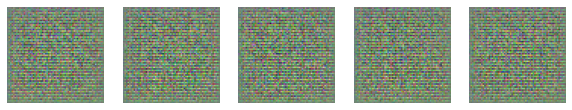

  1%|          | 1/161 [00:19<52:56, 19.85s/it]


d_loss:  1.5997896194458008 	g_loss:  6.460328102111816 
D(x):  0.482528954744339 	D(G(z1)):  0.46042272448539734 	D(G(z2)):  0.002297211904078722


  0%|          | 0/161 [00:00<?, ?it/s]

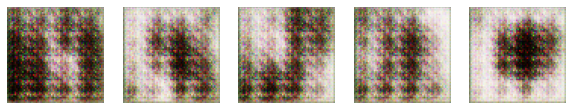

  1%|          | 1/161 [00:18<49:09, 18.43s/it]


d_loss:  0.9741657376289368 	g_loss:  2.6381070613861084 
D(x):  0.6352897882461548 	D(G(z1)):  0.31538981199264526 	D(G(z2)):  0.09607132524251938


  0%|          | 0/161 [00:00<?, ?it/s]

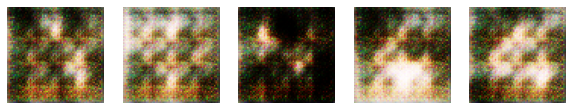

  1%|          | 1/161 [00:17<47:57, 17.99s/it]


d_loss:  0.4892388582229614 	g_loss:  3.195800542831421 
D(x):  0.7771519422531128 	D(G(z1)):  0.1572820246219635 	D(G(z2)):  0.062287118285894394


100%|██████████| 161/161 [47:25<00:00, 17.67s/it]


In [29]:
d_losses = []
g_losses = []
iters = 0

for epoch in range(num_epochs):
  for batch_i, data in enumerate(tqdm(dataloader, total=int(len(dataloader)))):
    # Trening Diskriminatora
    discrimintaor.zero_grad()

    batch_size = data.shape[0]
    data = data.to(device)

    label = torch.full((batch_size,), real_label, device=device, dtype=torch.float)

    output = discrimintaor(data).reshape(-1)
    d_loss_real = loss_fn(output, label)
    d_loss_real.backward()
    d_x = output.mean().item()

    noise = torch.randn(batch_size, channel_noise, 1, 1).to(device)
    fake = generator(noise).to(device)
    label.fill_(fake_label)

    output = discrimintaor(fake.detach()).reshape(-1)
    
    d_loss_fake = loss_fn(output, label)
    d_loss_fake.backward()
    d_g_z1 = output.mean().item()

    d_loss_total = d_loss_real + d_loss_fake

    d_optimizer.step()

    # Trening Generatora
    generator.zero_grad()
    label.fill_(real_label)

    output = discrimintaor(fake).reshape(-1)
    g_loss = loss_fn(output, label)
    g_loss.backward()
    d_g_z2 = output.mean().item()
    g_optimizer.step()

    d_losses.append(d_loss_total.item())
    g_losses.append(g_loss.item())

    if batch_i == 0:
      plt.figure(figsize=(10,7))
      for i , img in enumerate(fake[:5], 1):
        img = img.cpu().detach().numpy().transpose((1, 2, 0))
        img = 0.5 * img + 0.5
        img = np.clip(img, 0, 1)
        plt.axis('off')
        plt.subplot(1, 5, i)
        plt.imshow(img)
      plt.axis('off')
      plt.show()

      print('\nd_loss: ', d_loss_total.item(), '\tg_loss: ', g_loss.item(),
            '\nD(x): ', d_x, '\tD(G(z1)): ', d_g_z1, '\tD(G(z2)): ', d_g_z2
      )

    iters += 1

Prikaz dijagrama gubitaka po iteracijama

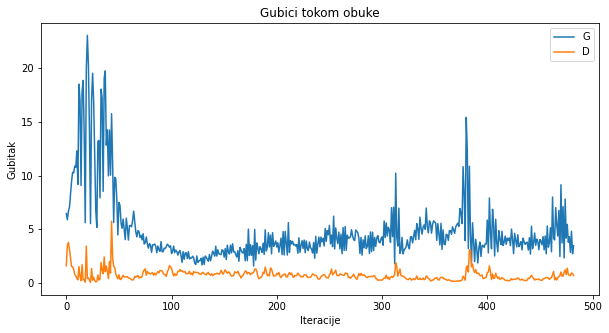

In [30]:
plt.figure(figsize=(10,5))
plt.title("Gubici tokom obuke")
plt.plot(g_losses, label="G")
plt.plot(d_losses, label="D")
plt.xlabel("Iteracije")
plt.ylabel("Gubitak")
plt.legend()
plt.show()